# 03.04 cubic spines

##### code, support for section text

In [1]:
if False: # settings for sensei
  from google.colab import auth
  from googleapiclient.discovery import build

  auth.authenticate_user()
  about = build('drive','v3').about().get(fields='user').execute()
  if about['user']['displayName'] == "Sun K.":

    # output to pdf setting
    from google.colab import output
    output.no_vertical_scroll()
    #output.no_horizontal_scroll() # sigh, doesnt exist

In [2]:
if True: # settings for the people
  import matplotlib.pyplot as plt
  import numpy as np
  import numpy.polynomial as npp
  import scipy as sp
  from tabulate import tabulate


###### code, utility

In [3]:
def parabolic_cubic_spline(xs,ys,ni):
  """
  xs : x-data
  ys : y-data
  ni : number of model evaluation points for each spline
  returns : model values, concatenated string of spline component functions
  examples:
    >>> xs_cub,ys_cub,s_cub = parabolic_cubic_spline([0,1,2,3,4,5],[3,1,4,1,2,0],20)
    >>> print(s_cub)
  """
  n = len(ys) # larger than n-1 bc extra equation
  xs_spline = np.zeros((n-1)*ni+1)
  ys_spline = np.zeros((n-1)*ni+1)
  s_spline = ""

  δ = [] # x[i+1] - x[i]
  Δ = [] # y[i+1] - y[i]
  for i in range(n-1):
    δ.append(xs[i+1]-xs[i])
    Δ.append(ys[i+1]-ys[i])

  lhs = np.zeros((n,n))
  rhs = np.zeros((n))
  lhs[0,0] =  1; lhs[-1,-1] =  1
  lhs[0,1] = -1; lhs[-1,-2] = -1 # added this one line for parabolic!
  for i in range(1,n-1):
    lhs[i,i-1] = δ[i-1]
    lhs[i,i] = 2*(δ[i-1]+δ[i])
    lhs[i,i+1] = δ[i]
    rhs[i] = 3*(Δ[i]/δ[i] - Δ[i-1]/δ[i-1])
  cs = np.linalg.solve(lhs,rhs)

  bs = []
  ds = []
  for i in range(n-1):
    ds.append((cs[i+1]-cs[i])/(3*δ[i]))
    bs.append(Δ[i]/δ[i] - (2*cs[i] + cs[i+1])*δ[i]/3)

  coeffs = []
  ss = []
  for i in range(n-1):
    if xs[i] != 0:
      coeffs.append([ds[i],cs[i],bs[i],ys[i]]) # np.polyId: low to high degree
      ss.append(np.poly1d(coeffs[i],variable ="(x-"+str(xs[i])+")")) # shift
    else:
      coeffs.append([ys[i],bs[i],cs[i],ds[i]]) # npp.Polynomial: high-to-low
      ss.append(npp.Polynomial(coeffs[i]))

  # string description of spline component functions
  for i,s in enumerate(ss):
    #s_spline += s.__str__() + "\n"
    s_spline += f"S{i}:\n\n{s.__str__()}\n\n"

  # build model values
  for i,s in enumerate(ss):
    xs_i = np.linspace(xs[i],xs[i+1],ni+1)
    i_from = ni*i
    i_thru = ni*(i+1)+1
    xs_spline[i_from:i_thru] = xs_i.copy()
    if xs[i] != 0:
      ys_spline[i_from:i_thru] = s(xs_i - xs[i]) # np.polyId, with shift
    else:
      ys_spline[i_from:i_thru] = s(xs_i) # via npp.Polynomial, without shift

  return xs_spline,ys_spline,s_spline


###### code, images in order of appearance

In [4]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html

def img_first(spline="linear"):

  x = [1,2,4,5]
  y = [2,1,4,3]
  cs_default = sp.interpolate.CubicSpline(x,y)
  cs = sp.interpolate.CubicSpline(x,y,bc_type='natural')

  xs = np.arange(1,5.1,0.1)

  # plot, cfg
  plt.close("all")

  #plot, data
  plt.plot(x,y,'o',label='data')
  if spline != "cubic":
    plt.plot(x,y,linestyle="-",label="LOL") #label='linear')
  if spline != "linear":
    plt.plot(xs,cs_default(xs), label="cubic")
  if spline == "all":
    plt.plot(xs,cs(xs),label="natural")
    plt.plot(xs,cs(xs,1),label="S'")
    plt.plot(xs,cs(xs,2),label="S''")
    plt.plot(xs,cs(xs,3),label="S'''")

  # plot, style
  plt.grid()
  plt.title("my first spline\n")
  plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
  plt.ylabel("y")
  plt.xlabel("x")
  # plot, show
  plt.show()


In [5]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html

def img_property_04():

  xx = [0,1,2,3,4,5]
  yy = [3,1,4,1,2,0]

  h = 0.1
  xs = np.arange(xx[0],xx[-1]+h/2,h)

  # plot, cfg
  plt.close("all")

  #plot, data
  plt.plot(xx,yy,'o',label='data')
  cs = sp.interpolate.CubicSpline(xx,yy,bc_type='natural')
  plt.plot(xs,cs(xs),label="natural")
  cs = sp.interpolate.CubicSpline(xx,yy) # default
  plt.plot(xs,cs(xs),label="not-a-knot")
  cs = sp.interpolate.CubicSpline(xx,yy,bc_type='clamped')
  plt.plot(xs,cs(xs),label="clamped")
  # fyi, scipy doesnt currently offer parabolic?
  xs_parabolic,ys_parabolic,s_parabolic = parabolic_cubic_spline(xx,yy,10)
  plt.plot(xs_parabolic,ys_parabolic,label="parabolic")

  # plot, style
  plt.title("various endpoints\n")
  plt.ylabel("y")
  plt.xlabel("x")
  plt.grid()
  plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
  # plot, show
  plt.show()


###### code, examples

In [6]:
# bc im even lazier

def eg_14():

  #input = [[0,3],[1,-2],[2,1]]
  xs = [0,1,2]
  ys = [3,-2,1]
  n = len(ys) # larger than n-1 bc extra equation

  δ = [] # x[i+1] - x[i]
  Δ = [] # y[i+1] - y[i]
  for i in range(n-1):
    δ.append(xs[i+1]-xs[i])
    Δ.append(ys[i+1]-ys[i])

  lhs = np.zeros((n,n))
  rhs = np.zeros((n))
  lhs[0,0] = 1; lhs[-1,-1] = 1
  for i in range(1,n-1):
    lhs[i,i-1] = δ[i-1]
    lhs[i,i] = 2*(δ[i-1]+δ[i])
    lhs[i,i+1] = δ[i]
    rhs[i] = 3*(Δ[i]/δ[i] - Δ[i-1]/δ[i-1])
  cs = np.linalg.solve(lhs,rhs)

  bs = []
  ds = []
  for i in range(n-1):
    ds.append((cs[i+1]-cs[i])/(3*δ[i]))
    bs.append(Δ[i]/δ[i] - (2*cs[i] + cs[i+1])*δ[i]/3)

  coeffs = []
  ss = []
  for i in range(n-1):
    if xs[i] != 0:
      coeffs.append([ds[i],cs[i],bs[i],ys[i]]) # np.polyId: high-to-low degree
      ss.append(np.poly1d(coeffs[i],variable ="(x-"+str(xs[i])+")")) # shift
    else:
      coeffs.append([ys[i],bs[i],cs[i],ds[i]]) # npp.Polynomial: low-to-high
      ss.append(npp.Polynomial(coeffs[i]))

  # plot, cfg
  plt.close("all")

  # plot, data
  plt.scatter(xs,ys,marker="o",label="input")
  for i,s in enumerate(ss):
    xs_i = np.linspace(xs[i],xs[i+1],21)
    if xs[i] != 0:
      ys_i = s(xs_i - xs[i]) # np.polyId, with shift
    else:
      ys_i = s(xs_i) # via npp.Polynomial, without shift
    plt.plot(xs_i,ys_i,c="C"+str(i+1),label="spline "+str(i+1))

  # plot, style
  plt.grid()
  plt.title(f"eg 14, natural spline\n")
  plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
  plt.ylabel("why not")
  plt.xlabel("x")
  # plot, show
  plt.show()

  # display component splines
  for i,s in enumerate(ss):
    print(f"\nspline {i+1} : \n\n{s}")


## 0 intro

so theres interpolating polynomials for (sort-of) random $x_i$, evenly spaced $x_i$ and chebyshev $x_i$. what about other ways to connect the dots? what if the word "continuous" gets taken away?

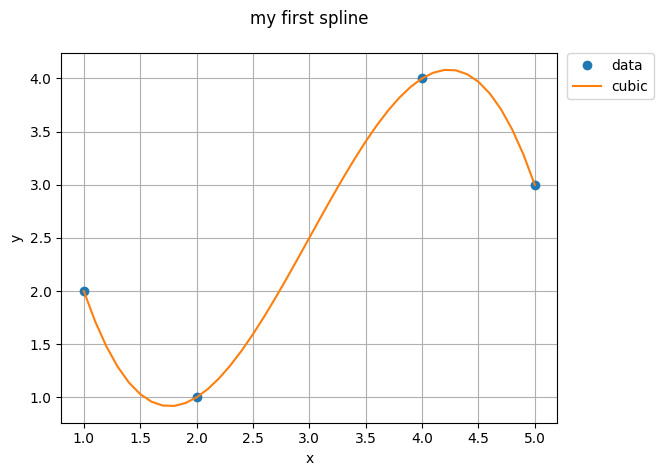

In [9]:
img_first(spline="cubic")

no ones gonna pay money for that but lets write it out seriously:

\begin{align}
 S_1(x) &= 2 - (x-1) \quad\text{on }[1,2] \\
 S_2(x) &= 1 + \frac{3}{2}(x-2) \quad\text{on }[2,4] \\
 S_3(x) &= 4 - (x-4) \quad\text{on }[4,5]. \\
\end{align}

and if it smoothed out in a cubic-spline kind of way,

\begin{align}
 S_1(x) &= 2 - \frac{13}{8}(x-1) + 0\cdot(x-1)^2 + \frac{5}{8}(x-1)^3 \quad\text{on }[1,2] \\
 S_2(x) &= 1 + \frac{1}{4}(x-2) + \frac{15}{8}(x-2)^2 - \frac{5}{8}(x-2)^3 \quad\text{on }[2,4] \\
 S_3(x) &= 4 + \frac{1}{4}(x-4) - \frac{15}{8}(x-4)^2 + \frac{5}{8}(x-4)^3 \quad\text{on }[4,5]. \\
\end{align}

note the smooth transition from one $S_i$ to the next at the middle base points, or "knots". this is achieved by having neighboring pieces $S_i,S_{i+1}$ have the same zeroth, first and second derivatives at those points.

given $n$ points $(x_1,y_1),\dots,(x_n,y_n)$, there is only one linear spline but there are infinitely many cubic splines. ie, more conditions are needed to decide the spline.

## 1 properties of splines

assume the $n$ given data points $(x_1,y_1),\dots,(x_n,y_n)$ are of distinct $x_i$ and in increasing order. a <b>cubic spline</b> $S(x)$ through data points $(x_1,y_1),\dots,(x_n,y_n)$ is a set of cubic polynomials.

\begin{align}
  S_1(x) &= y_1 + b_1(x-x_1) + c_1(x-x_1)^2 + d_1(x-x_1)^3 \quad\text{on }[x_1,x_2] \\
  S_2(x) &= y_2 + b_2(x-x_2) + c_2(x-x_2)^2 + d_2(x-x_2)^3 \quad\text{on }[x_2,x_3] \\
  &\vdots \\
  S_{n-1}(x) &= y_{n-1} + b_{n-1}(x-x_{n-1}) + c_{n-1}(x-x_{n-1})^2 + d_{n-1}(x-x_{n-1})^3 \quad\text{on }[x_{n-1},x_n] \\
\end{align}

with the following properties:

<b><font color=grey>property 01</font></b> $S_i(x_i) = y_i, S_i(x_{i+1}) = y_{i+1}$ for $i = 1,\dots,n-1$.

<b><font color=grey>property 02</font></b> $S_{i-1}'(x_i) = S_i(x_i)'$ for $i = 2,\dots,n-1$.

<b><font color=grey>property 03</font></b> $S_{i-1}''(x_i) = S_i(x_i)''$ for $i = 2,\dots,n-1$.

property 01 guarantees that spline $S(x)$ interpolates the data points; property 02 forces the slopes neighboring segments to agree where they meet; property 03 does the same wrt curvature.

<b><font color=grey>property 04a</font></b> <b>natural spline</b> $S_1''(x_1) = 0, S_{n-1}''(x_n) = 0$.

$n$ points will have $n-1$ segments, each represented by a cubic and each cubic will have a coefficient for each of its term. term $a_0x^0 = y_i$, leaving $b_i\equiv a_2,c_i\equiv a_i, d_i \equiv a_3$ per equation $i$.

property 1 at $x_{i+1} \rightarrow n-1$ equations:

\begin{align}
  y_2 &= S_1(x_2) = y_1 + b_1(x_2 - x_1) + c_1(x_2-x_1)^2 + d_1(x_2-x_1)^3 \\
  &\vdots \\
  y_n &= S_{n-1}(x_n) = y_{n-1} + b_{n-1}(x_n - x_{n-1}) + c_{n-1}(x_n-x_{n-1})^2 + d_{n-1}(x_n-x_{n-1})^3.
\end{align}

property 02 $\rightarrow n-2$ equations:

\begin{align}
  0 &= S_1'(x_2) - S_2'(x_2) = b_1 + 2c_1(x_2-x_1) + 3d_1(x_2-x_1)^2 - b_2 \\
  &\vdots \\
  0 &= S_{n-2}'(x_{n-1}) - S_{n-1}'(x_{n-1}) = b_{n-2} + 2c_{n-2}(x_{n-1}-x_{n-2}) + 3d_{n-2}(x_{n-1}-x_{n-2})^2 - b_{n-1}.
\end{align}

property 03 $\rightarrow n-2$ equations:

\begin{align}
  0 &= S_1''(x_2) - S_2''(x_2) = 2c_1 + 6d_1(x_2-x_1) - 2c_2 \\
  &\vdots \\
  0 &= S_{n-2}''(x_{n-1}) - S_{n-1}''(x_{n-1}) = 2c_{n-2} + 6d_{n-2}(x_{n-1}-x_{n-2}) - 2c_{n-1}.
\end{align}

instead of solving $3\times (n-1)$ equations all at once, break it down. find $c_i$ within a subset of those equations, then solve out from there.

consider $c_n = S_{n-1}''(x_n) \cdot \frac{1}{2}$. let $\delta_i = x_{i+1}-x_i, \Delta_i = y_{i+1}-y_i$. then property 03 equations resolve to

$$d_i = \frac{c_{i+1}-c_i}{3\delta_i} \quad i = 1,\dots,n-1$$

and property 01 equations reduce to

\begin{align}
  b_i &= \frac{\Delta_i}{\delta_i} - c_i\delta_i - d_i\delta_i^2 \\
  &= \frac{\Delta_i}{\delta_i} - c_i\delta_i - \frac{\delta_i}{3}(c_{i-1}-c_i) \\
  &= \frac{\Delta_i}{\delta_i} - \frac{\delta_i}{3}(2c_i - c_{i+1}) \quad i = 1,\dots,n-1.
\end{align}

ie, both $b,d$ are both in terms of $c$. so

\begin{align}
  \delta_1c_1 + 2(\delta_1+\delta_2)c_2 + \delta_2 c_3 &= 3 \left( \frac{\Delta_2}{\delta_2}-\frac{\Delta_1}{\delta_1} \right) \\
  &\vdots \\
  \delta_{n-2}c_{n-2} + 2(\delta_{n-2}+\delta_{n-1})c_{n-1} + \delta_{n-1} c_n &= 3 \left( \frac{\Delta_{n-1}}{\delta_{n-1}}-\frac{\Delta_{n-2}}{\delta_{n-2}} \right).
\end{align}

<b><font color=grey>property 04a</font></b> <b>natural splines</b> $\rightarrow$ 2 equations:

\begin{align}
  S_1''(x_1) &= 0 \rightarrow 2c_1 = 0 \\
  S_{n-1}''(x_n) &= 0 \rightarrow 2c_n = 0.
\end{align}

$n$ equations, $n$ unknowns in $c_i$,

$$
\begin{bmatrix}
  1 & 0 & 0 \\
  \delta_1 & 2\delta_1 + 2\delta_2 & \delta_2 & \ddots \\
  0 & \delta_2 & 2\delta_2 + 2\delta_3 & \delta_3 & \ddots \\
  & \ddots & \ddots & \ddots & \ddots \\
  &&& \delta_{n-2} & 2\delta_{n-2} + 2\delta_{n-1} & \delta_{n-1} \\
  &&& 0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
  c_1 \\ \text{ } \\ \text{ } \\ \text{ } \vdots \\ \text{ } \\ c_n
\end{bmatrix}
=
\begin{bmatrix}
  0 \\ 3\left( \frac{\Delta_2}{\delta_2} - \frac{\Delta_1}{\delta_1} \right) \\ \text{ } \\ \vdots \\ 3\left( \frac{\Delta_{n-1}}{\delta_{n-1}} - \frac{\Delta_{n-2}}{\delta_{n-2}} \right) \\ 0
\end{bmatrix}.
$$

then solve for $b_i,d_i$ directly from $c_i$. which proves the following theorem.

<b><font color=grey>theorem 07</font></b> for a set of data points $(x_1,y_1),\dots,(x_n,y_n)$ with distinct $x_i$, there is a unique natural cubic spline fitting the points.

##### algorithm <b>natural cubic spline</b>

```
# given x = [x(1),...,x(n)] where x(1)<...<x(n),y=[y(1),...,y(n)]

for i = 1 : n-1
  a(i) = y(i)
  δ(i) = x(i+1) - x(i)
  Δ(i) = y(i+1) - y(i)
end

solve for c(1),...,c(n)

for i = 1 : n-1
  d(i) = (c(i+1)-c(i))/(3*δ(i))
  b(i) = Δ(i)/δ(i) - (2c(i)+c(i+1))*δ(i)/3
end
```

the natural cubic spline is

$$
S_i(x) = a_i + b_i(x-x_i)+c_i(x-x_i)^2 + d_i(x-x_i)^3 \text{ on }[x_i,x_{i+1}] \text{ for } i = 1,\dots,n-1.
$$

##### example 14

find natural cubic spline through $(0,3),(1,-2),(2-1)$.

for $c_i$ where $n=3$,

$$
\begin{bmatrix} 1 & 0 & 0 \\ 1 & 4 & 1 \\ 0 & 0 & 1 \end{bmatrix}
\begin{bmatrix} c_1 \\ c_2 \\ c_3 \end{bmatrix}
=
\begin{bmatrix} 0 \\ 24 \\ 0 \end{bmatrix}
$$

###### code

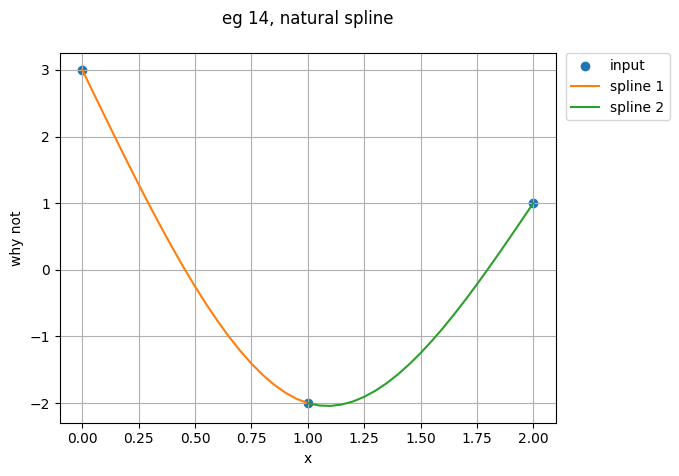


spline 1 : 

3.0 - 7.0·x + 0.0·x² + 2.0·x³

spline 2 : 

        3         2
-2 (x-1) + 6 (x-1) - 1 (x-1) - 2


In [ ]:
eg_14() # bc im even lazier

## 2 endpoint conditions

<b><font color=grey>property 04b</font></b> <b>curvature-adjusted cubic spline</b>. $S_1''(x_1), S_{n-1}''(x_n)$ set to arbitrary non-zero values.

<b><font color=grey>property 04c</font></b> <b>clamped cubic spline</b>. $S_1'(x_1), S_{n-1}'(x_n)$ set to arbitrary non-zero values.

<b><font color=grey>property 04d</font></b> <b>parabolically terminated cubic spline</b>. first and last points are forced to be at most degree two by specifying $d_1 = 0 = d_{n-1}$. equivalently, we can require $c_1=c_2,c_{n-1}=c_n$, which reduces the matrix equation to a strictly diagonally dominant $n-2\times n-2$ matrix equation in $c_2,c_{n-1}$.

<b><font color=grey>property 04e</font></b> <b>not-a-knot cubic spline</b>. $S_1'''(x_2) = S_2'''(x_2), S_{n-2}'''(x_{n-1}) = S_{n-1}'''(x_{n-1})$ set to arbitrary non-zero values. ie, the third derivatives here cause $S_1=S_2,S_{n-2}=S_{n-1}$. eg, this means $x_2$ doesnt need to be a base point bc $S_2=S_1$.

<b><font color=grey>theorem 08</font></b>. assume $n\ge 2$. then for set of data points $(x_1,y_1),\dots,(x_n,y_n)$ and for any one of end conditions given by properties 4a-4c, there is a unique cubic spline satisfying the end conditions and fitting the points. the same is true assuming $n\ge 3$ for property 4d and $n\ge4$ for 4e.

###### code

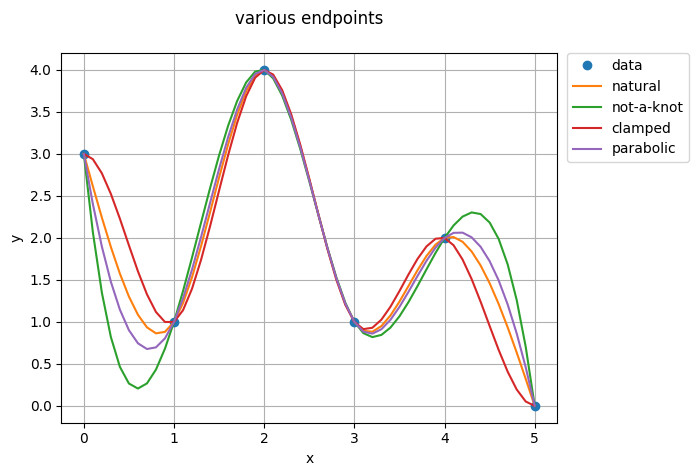

In [ ]:
img_property_04()